In [1]:
#structure of inception #
import torch
from torch import nn
from torch.nn import functional as F


class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs): 
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)  
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1)

In [2]:
#structure of Googlenet#
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32), 
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))


In [3]:
#download mnist and #
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import os
import cv2

EPOCH = 10  
BATCH_SIZE = 200
LR = 0.001  


train_data = torchvision.datasets.MNIST(
    root='./data/',  
    train=True,  
    transform=torchvision.transforms.ToTensor(),  
    download=True,  
)

train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True  
)

test_data = torchvision.datasets.MNIST(
    root='./data/',
    train=False
)

test_x = torch.unsqueeze(test_data.train_data, dim=1).type(torch.FloatTensor)/255
test_y = test_data.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
import time

print_every_batch=50

optimizer = torch.optim.Adam(net.parameters(), lr=LR)

loss_func = nn.CrossEntropyLoss()  

list_lost=[]
list_accuracy=[]
list_epoch_time=[]

for epoch in range(EPOCH):
    epoch_start_time = time.time()
    for batch_id, (batch_x, batch_y) in enumerate(train_loader):  
        output = net(batch_x)  
        loss = loss_func(output, batch_y)  
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  

        
        if batch_id % print_every_batch == 0:
            test_output = net(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            list_lost.append(loss.data.numpy())
            list_accuracy.append(accuracy)
            
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print("Epoch %d of %d with %.2f s" % (epoch + 1, EPOCH, per_epoch_ptime))
    list_epoch_time.append(per_epoch_ptime)

Epoch:  0 | train loss: 2.3050 | test accuracy: 0.11
Epoch:  0 | train loss: 2.3031 | test accuracy: 0.11
Epoch:  0 | train loss: 2.1962 | test accuracy: 0.21
Epoch:  0 | train loss: 1.6170 | test accuracy: 0.31
Epoch:  0 | train loss: 1.2167 | test accuracy: 0.41
Epoch:  0 | train loss: 1.2891 | test accuracy: 0.55
Epoch 1 of 10 with 123.96 s
Epoch:  1 | train loss: 1.0246 | test accuracy: 0.57
Epoch:  1 | train loss: 0.7098 | test accuracy: 0.76
Epoch:  1 | train loss: 0.7870 | test accuracy: 0.54
Epoch:  1 | train loss: 0.6788 | test accuracy: 0.81
Epoch:  1 | train loss: 0.6045 | test accuracy: 0.84
Epoch:  1 | train loss: 0.4884 | test accuracy: 0.90
Epoch 2 of 10 with 121.75 s
Epoch:  2 | train loss: 0.4499 | test accuracy: 0.86
Epoch:  2 | train loss: 0.3777 | test accuracy: 0.89
Epoch:  2 | train loss: 0.4066 | test accuracy: 0.88
Epoch:  2 | train loss: 0.4720 | test accuracy: 0.93
Epoch:  2 | train loss: 0.5278 | test accuracy: 0.83
Epoch 3 of 10 with 129.38 s
Epoch:  3 | tra

In [5]:
import numpy as np
lost_array=np.array(list_lost)
list_accuracy=np.array(list_accuracy)
list_epoch_time=np.array(list_epoch_time)

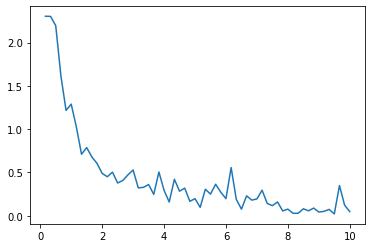

In [6]:
plt.plot(np.array(list(range(1,61)))/6,lost_array)

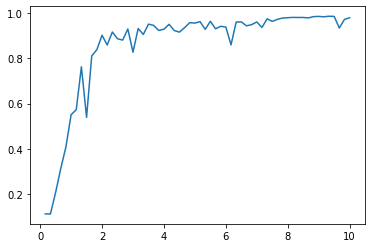

In [7]:
plt.plot(np.array(list(range(1,61)))/6,list_accuracy)

In [8]:
sum(list_epoch_time)/10

127.78432106971741

In [9]:
torch.save(net, "googlenet.pth")  

In [10]:
model = torch.load("googlenet.pth")
print(model)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Inception(
      (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (p2_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (p3_1): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (p3_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (p4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (p4_2): Conv2d(192, 32, ker

In [11]:
test_output = model(test_x)
pred_y = torch.max(test_output, 1)[1].data.numpy()
accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

Epoch:  9 | train loss: 0.1047 | test accuracy: 0.98


In [12]:
pred_y=pred_y.tolist()
test_y=test_y.tolist()

In [13]:
for i in range(1000):
    
    if pred_y[i]!=test_y[i]:
        print(i)

43
151
158
195
241
259
266
324
326
412
445
448
479
495
582
591
625
646
659
691
716
726
740
791
797
829
939
951
958


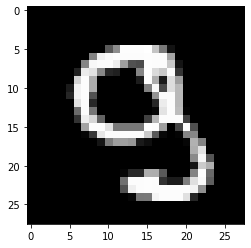

In [14]:
plt.imshow(test_x[151,0,:,:],cmap='gray')

In [15]:
pred_y[151]

8

In [16]:
test_y[151]

9